In [316]:
import pandas as pd
from fbprophet import Prophet
from  datetime import datetime, timedelta
import gc
import numpy as np
import matplotlib.pyplot as plt

In [317]:
import warnings
warnings.filterwarnings("ignore")

In [318]:
cal_dtype = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
              "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
              "month": "int16", "year": "int16", "snap_CA": "int8", 'snap_TX': 'int8', 'snap_WI': 'int8'}
price_dtype = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32"}

In [319]:
dt = pd.read_csv('sales_train_validation.csv')
dt = dt.astype({col: 'int32' for col in dt.select_dtypes('int64').columns})

In [320]:
cal = pd.read_csv('calendar.csv', dtype = cal_dtype)
cal['date'] = pd.to_datetime(cal['date'])
cal = cal.astype({col: 'int32' for col in cal.select_dtypes('int64').columns})
cal_1 = cal[0:1913]
future = cal[1913:1941]

In [321]:
hol_1 = cal[['event_name_1', 'date']]
hol_1 = hol_1.dropna()
hol_1 = hol_1.rename(columns={'date': 'ds', 'event_name_1': 'holiday'})
hol_2 = cal[['event_name_2', 'date']]
hol_2 = hol_2.dropna()
hol_2 = hol_2.rename(columns={'date': 'ds', 'event_name_2': 'holiday'})
hol = pd.concat([hol_1, hol_2], axis=0, sort=False)
hol['lower_window'] = 0
hol['upper_window'] = 1

In [7]:
#prices = pd.read_csv('sell_prices.csv', dtype = price_dtype)

In [322]:
val_values = pd.read_csv('validation_values.csv')

In [323]:
dt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [340]:
dt_st_dep = dt.groupby(['store_id', 'dept_id'], as_index=False).sum()
dt_st_dep.head(20)

,store_id,dept_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA_1,FOODS_1,297,284,214,175,182,191,224,263,...,293,317,268,302,237,287,297,331,419,329
1,CA_1,FOODS_2,674,655,396,476,354,486,554,747,...,435,499,637,529,391,423,365,489,590,734
2,CA_1,FOODS_3,2268,2198,1398,1607,1496,1730,1915,2952,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,CA_1,HOBBIES_1,528,489,409,383,263,453,339,750,...,370,690,597,517,461,333,380,471,621,641
4,CA_1,HOBBIES_2,28,9,6,9,5,14,7,19,...,31,32,58,25,34,30,30,56,49,73
5,CA_1,HOUSEHOLD_1,361,350,279,278,195,256,268,517,...,690,979,1010,718,621,665,580,695,933,1022
6,CA_1,HOUSEHOLD_2,181,170,114,123,135,146,143,189,...,185,255,285,199,189,204,186,205,319,324
7,CA_2,FOODS_1,406,408,238,240,220,263,304,353,...,535,504,515,327,366,422,334,579,623,520
8,CA_2,FOODS_2,212,227,138,174,102,103,140,189,...,431,561,693,454,436,450,349,396,620,782
9,CA_2,FOODS_3,1575,1286,913,1126,956,1128,1341,1843,...,1925,2358,2521,1844,1608,1634,1578,1896,2517,2710


In [325]:
temp = val_values
temp[['a', 'b', 'c', 'd', 'e', 'f']] = temp.id.str.split('_', expand=True)
temp['store_id'] = temp['d']+ '_' + temp['e']
temp['dep_id'] = temp['a']+ '_' + temp['b']
#temp = temp.drop(['a', 'b', 'c', 'd', 'e', 'f'], axis=1)
#temp = temp.drop(["('a', 'b', 'c', 'd', 'e', 'f')"], axis=1)
val_group = temp.groupby(['store_id', 'dep_id'], as_index=False).sum()
val_group.head()

,store_id,dep_id,F1,F2,F3,F4,F5,F6,F7,F8,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1,FOODS_1,294,259,268,328,387,455,403,262,...,412,435,415,277,302,397,330,310,427,334
1,CA_1,FOODS_2,458,500,412,400,463,653,720,620,...,545,611,781,555,476,427,411,434,627,719
2,CA_1,FOODS_3,2141,1759,1787,1718,2182,2842,3131,2396,...,2408,3000,3521,2366,2016,1992,2113,2249,2729,3274
3,CA_1,HOBBIES_1,546,395,418,385,550,574,625,478,...,546,732,631,389,347,353,354,494,656,588
4,CA_1,HOBBIES_2,43,31,33,47,34,62,59,51,...,42,74,56,28,46,28,52,45,63,58


In [352]:
def get_pred(d_id, s_id):
    
    val_n = val_group.loc[(val_group['dep_id'] == d_id) & (val_group['store_id'] == s_id)]
    val_n = val_n.reset_index(drop=True)
    y_lst = val_n.loc[0, :].values.tolist()
    y_lst.pop(0)
    y_lst.pop(0)
    
    dt_st_dep_n = dt_st_dep.loc[(dt_st_dep['dept_id'] == d_id) & (dt_st_dep['store_id'] == s_id)]

    catcols = ['store_id', 'dept_id']
    dt_st_dep_n = pd.melt(dt_st_dep_n, 
                        id_vars = catcols, 
                        value_vars = [col for col in dt_st_dep_n.columns if col.startswith('d_')], 
                        var_name = 'd', 
                        value_name = 'sales')
    dt_st_dep_n = dt_st_dep_n.merge(cal, on= "d", copy = False)
    df_train = dt_st_dep_n
    dates = df_train['date'].tolist()
    sales = df_train['sales'].tolist()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(sales, c='royalblue')
    ax = plt.gca()
    ax.set_ylabel('Sales')
    ax.set_xlabel('Dates')
    plt.show()
    tr_chk = df_train[['date', 'sales']]
    tr_chk = tr_chk.rename(columns={'date': 'ds', 'sales': 'y'})
    fut = future[['date']]
    fut = fut.rename(columns={'date': 'ds'})
    m = Prophet(holidays=hol, daily_seasonality=False)
    forecast = m.fit(tr_chk).predict(fut)
    tr_chk_2 = tr_chk
    fut_2 = fut
    if (s_id.split('_')[0] == 'CA'):
        tr_chk_2['snap'] = df_train['snap_CA']
        fut_2['snap'] = future['snap_CA']
    elif (s_id.split('_')[0] == 'TX'):
        tr_chk_2['snap'] = df_train['snap_TX']
        fut_2['snap'] = future['snap_TX']
    else:
        tr_chk_2['snap'] = df_train['snap_WI']
        fut_2['snap'] = future['snap_WI']
    m2 = Prophet(holidays=hol, daily_seasonality=False)
    m2.add_regressor('snap')
    forecast2 = m2.fit(tr_chk_2).predict(fut_2)
    y_pred = forecast['yhat'].values.tolist()
    y_pred_da_f = forecast2['yhat'].values.tolist()
    check = pd.DataFrame(columns = ['y_lst', 'y_pred_da_t', 'y_pred_da_f'])
    check['y_lst'] = y_lst 
    check['y_pred_da_t'] = y_pred
    check['y_pred_da_f'] = y_pred_da_f
    return(check)

In [353]:
def plot_res(d_id, s_id):
    check = get_pred(d_id, s_id)
    y_lst = check['y_lst'].tolist()
    y_pred = check['y_pred_da_t'].tolist()
    y_pred_da_f = check['y_pred_da_f'].tolist()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y_lst, c='royalblue')
    #plt.plot(y_pred, c='green')
    plt.plot(y_pred_da_f, c='black')
    ax = plt.gca()
    ax.set_ylabel('Sales')
    ax.set_xlabel('Dates')
    plt.show()
    plt.clf()

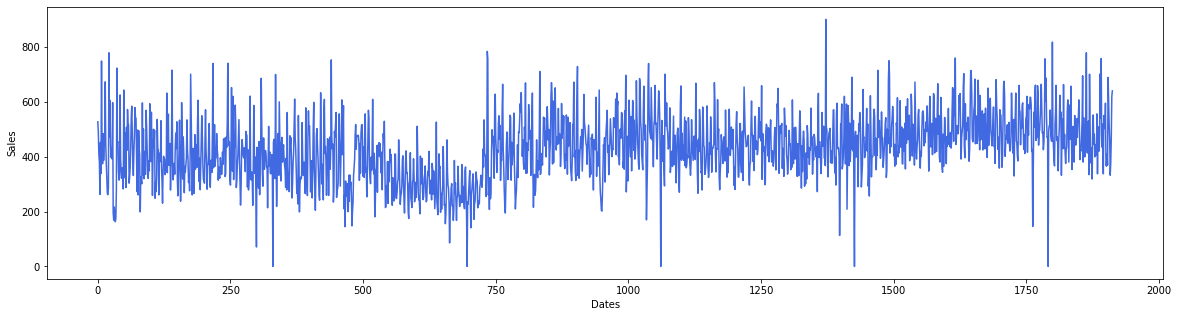

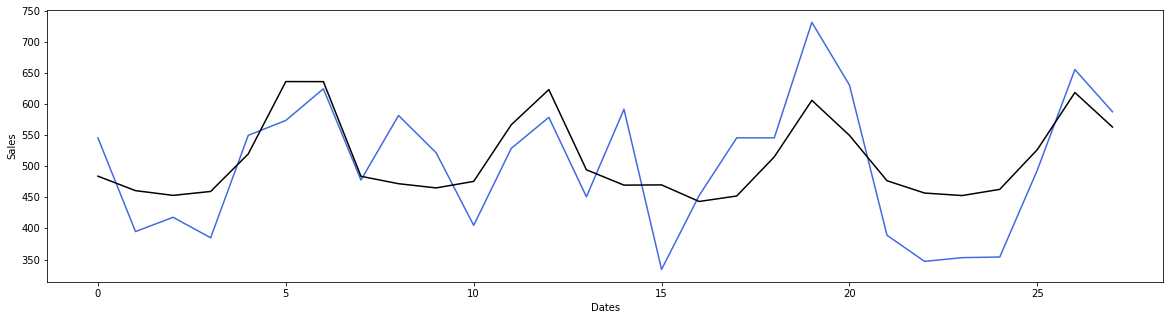

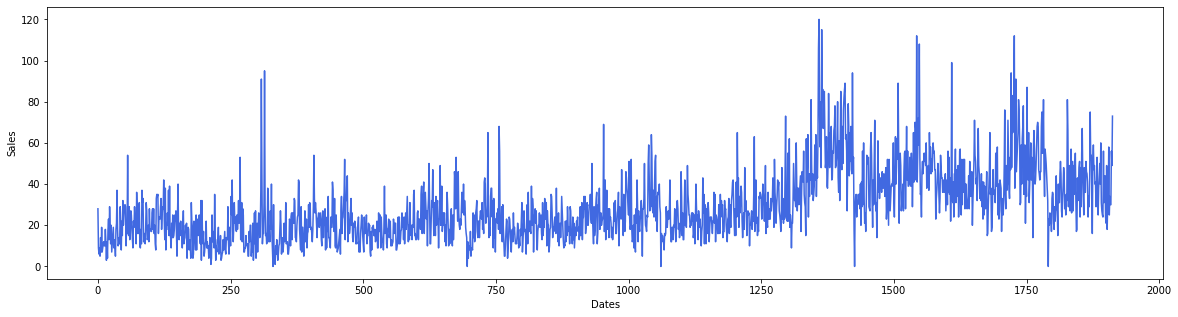

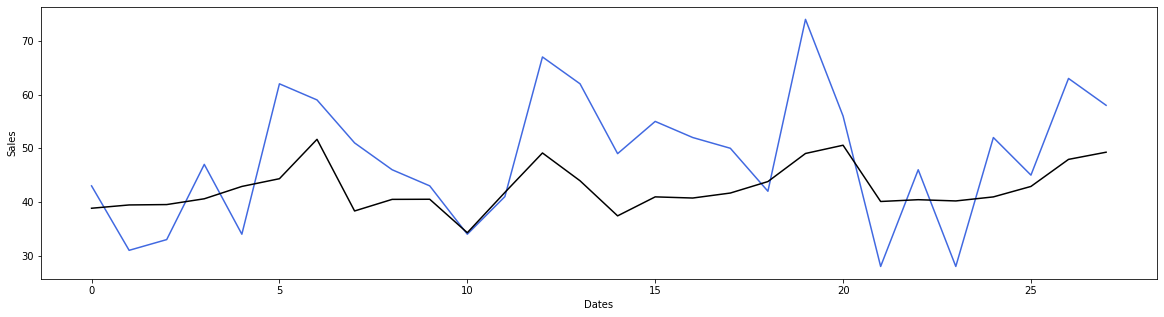

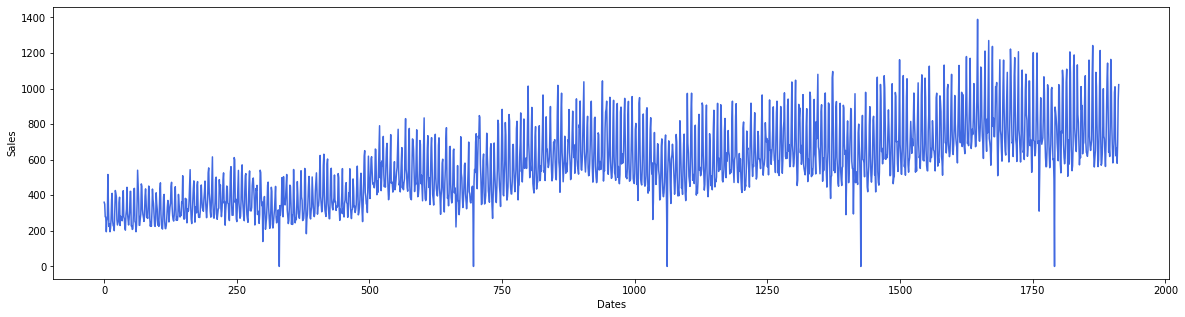

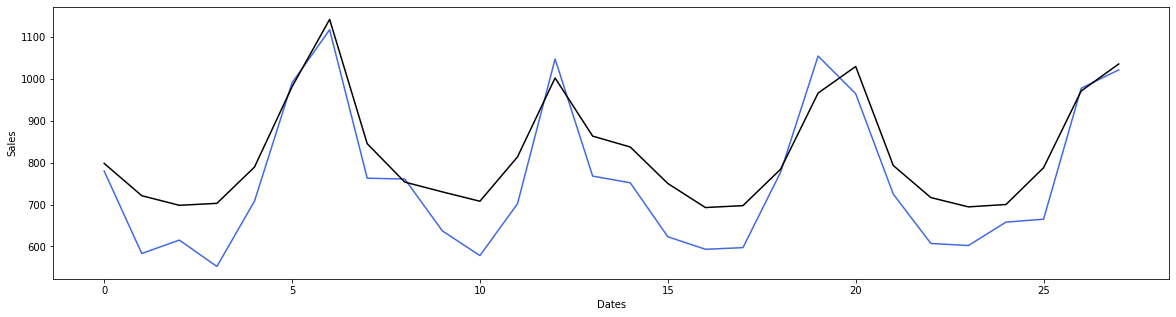

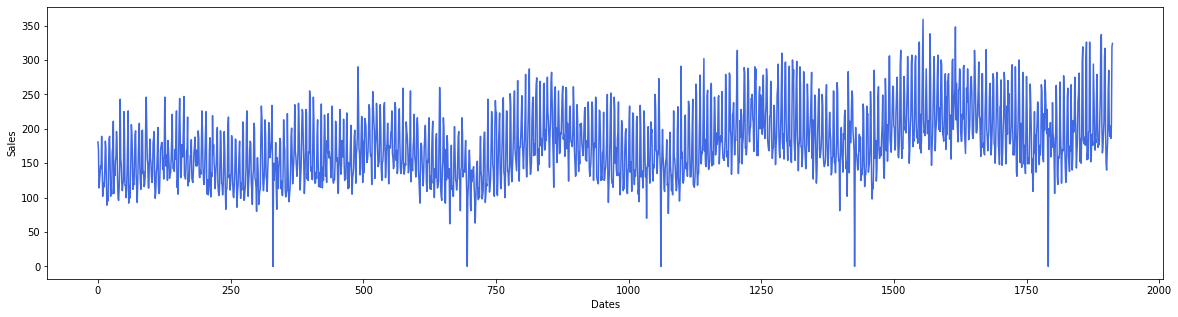

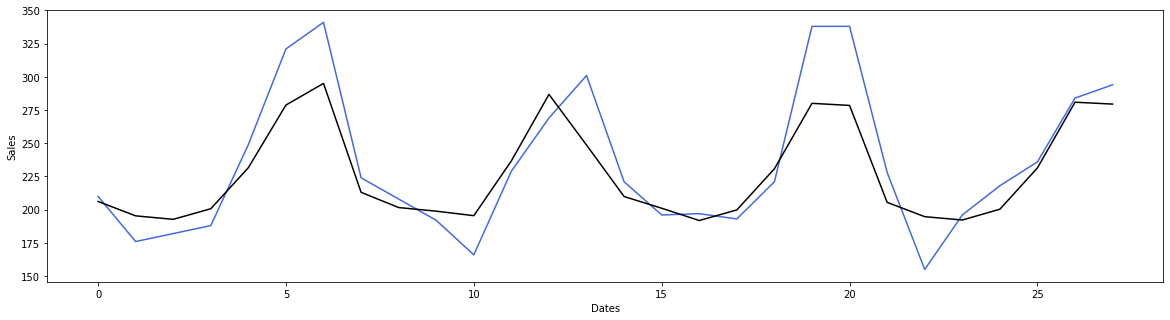

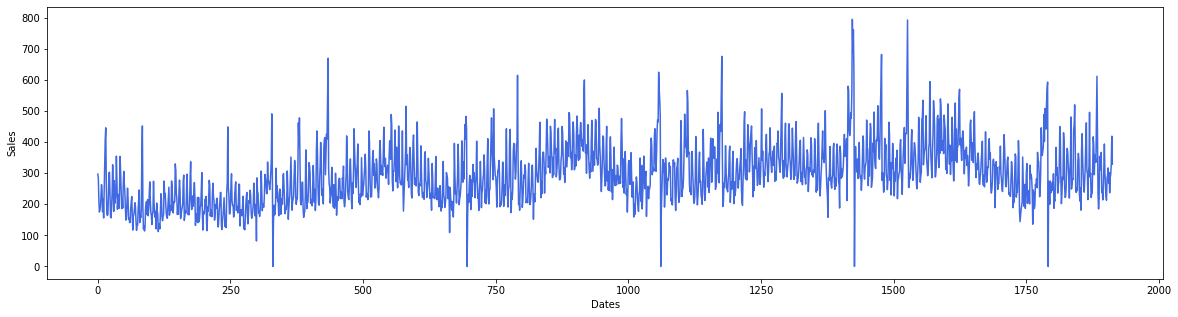

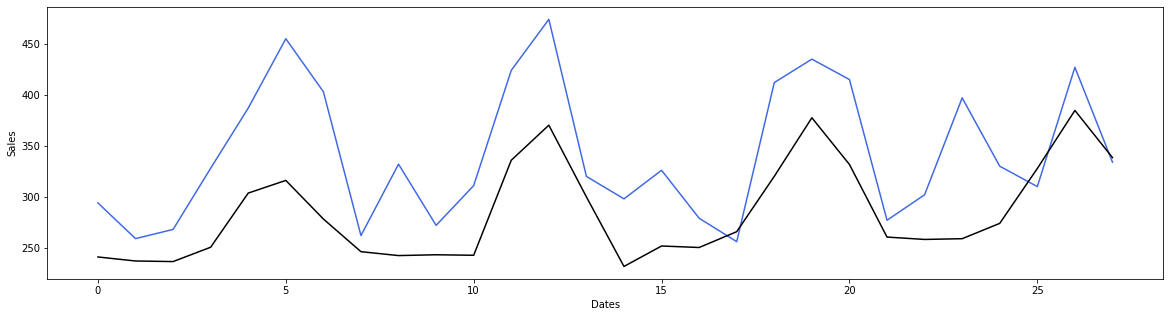

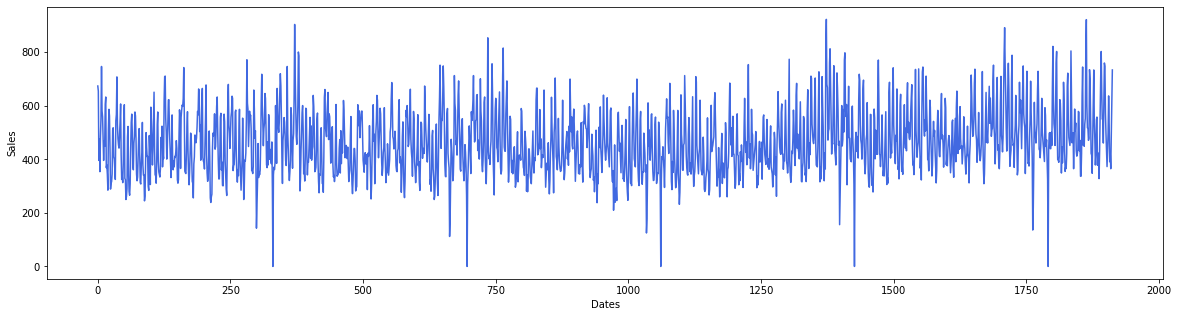

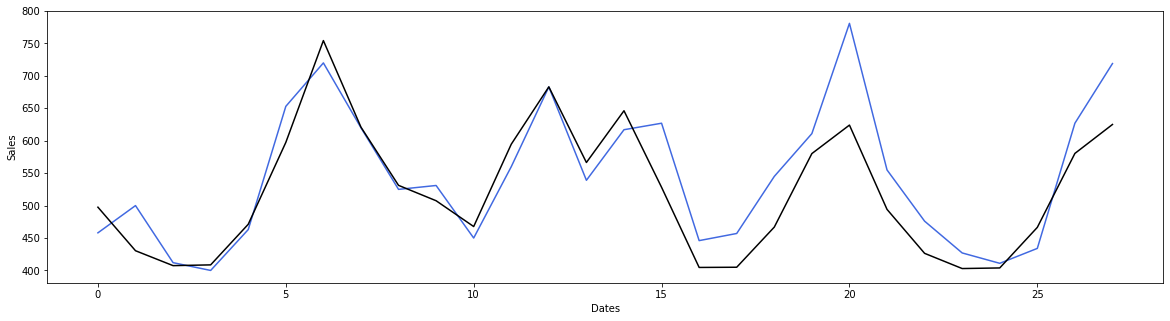

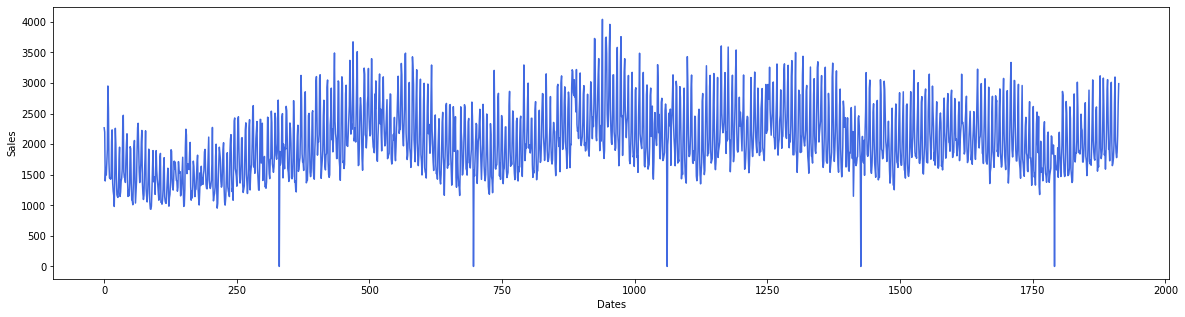

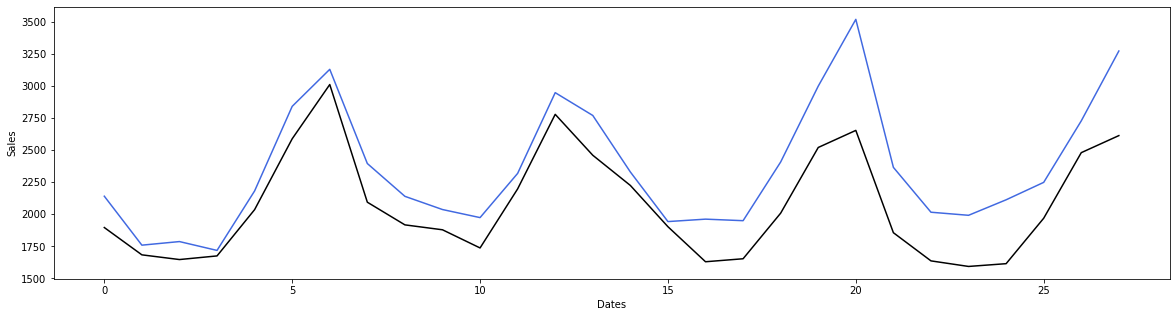

<Figure size 1440x360 with 0 Axes>

In [354]:
dep_id_lst = ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']
s_id = 'CA_1'
for d_id in dep_id_lst:
    plot_res(d_id, s_id)

In [48]:
COLUMN_NAMES = ['id', 'F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19',
               'F20', 'F21','F22','F23','F24','F25','F26','F27','F28']
sub_pro = pd.DataFrame(columns=COLUMN_NAMES)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
